# Курсовой проект

### Подключение необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [3]:
DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

**Задача** 

Предсказать цены на квартиры в датасете test.csv. Даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).

***1. Подготовка данных (анализ, визуализация, обработка выбросов, пропусков, генерация фичей)***

**Описание датасета**

Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [6]:
df = pd.read_csv(DATASET_PATH, sep=',')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [7]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


***Анализируем датасет на пропуски и типы данных***

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [9]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [10]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

**Приведение типов**

In [12]:
df['DistrictId'] = df['DistrictId'].astype(str)

In [13]:
df.drop(columns=['Id'], inplace=True)

**EDA и очистка данных**

Анализируем целевой признак Price

In [14]:
target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]

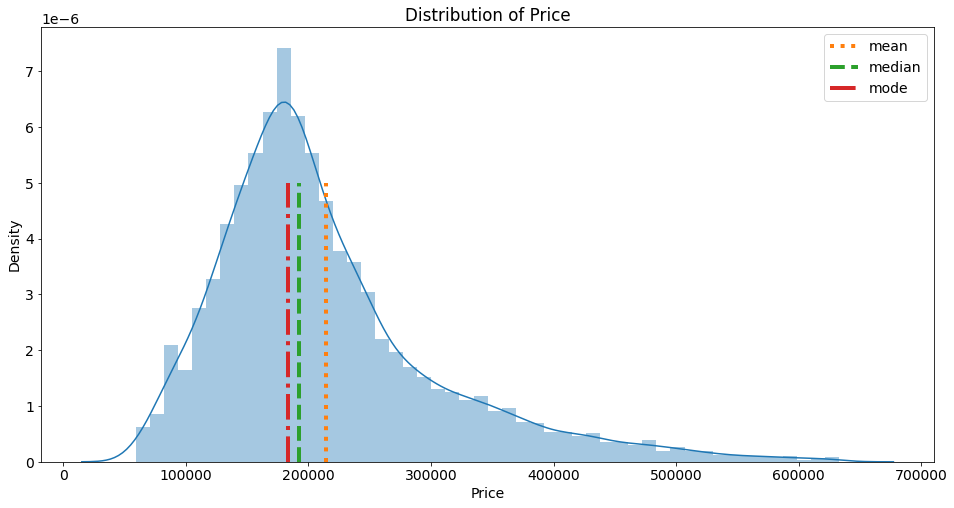

In [15]:
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=50)

y = np.linspace(0, 0.000005, 2)
plt.plot([target_mean] * 2, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 2, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 2, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

***Анализ категориальных признаков***

In [16]:
df.dtypes

DistrictId         object
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [17]:
df.select_dtypes(include=["category","object"])

,DistrictId,Ecology_2,Ecology_3,Shops_2
0,27,B,B,B
1,22,B,B,B
2,1,B,B,B
3,1,B,B,B
4,94,B,B,B
...,...,...,...,...
9995,61,B,B,B
9996,27,B,B,A
9997,178,B,B,B
9998,21,B,B,B


Text(0.5, 1.0, 'Shops_2')

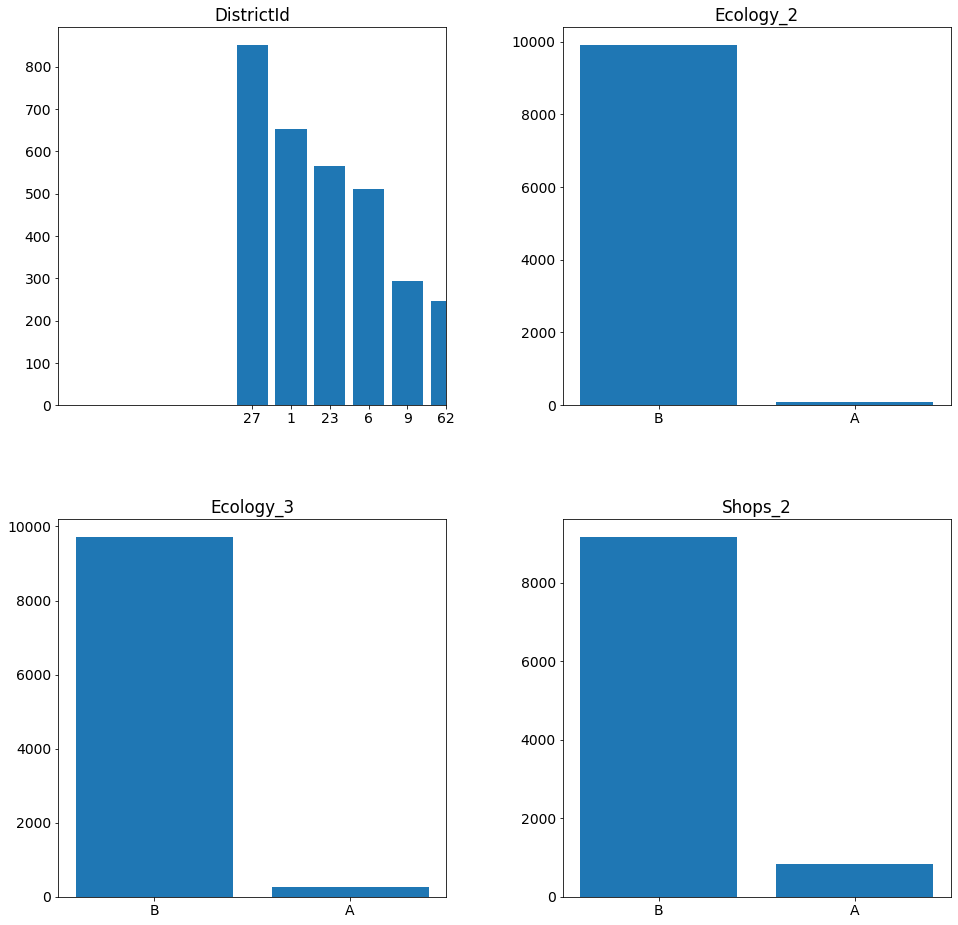

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2)
ax1, ax2, ax3, ax4 = ax.flatten()

fig.subplots_adjust(wspace=0.3, hspace=0.3)
fig.set_size_inches(16, 16)

ax1.bar(df['DistrictId'].value_counts().index, df['DistrictId'].value_counts().values)
ax1.set_title("DistrictId")
ax1.set_xlim([-5, 5])

ax2.bar(df['Ecology_2'].value_counts().index, df['Ecology_2'].value_counts().values)
ax2.set_title("Ecology_2")

ax3.bar(df['Ecology_3'].value_counts().index, df['Ecology_3'].value_counts().values)
ax3.set_title("Ecology_3")

ax4.bar(df['Shops_2'].value_counts().index, df['Shops_2'].value_counts().values)
ax4.set_title("Shops_2")

***Анализ количественных признаков***

In [19]:
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.859375
std,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517273,1.493601,4.806341,92872.289062
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


**Обработка пропусков**

In [20]:
df.isna().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [21]:
df.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [22]:
df['LifeSquare_nan'], df['Healthcare_1_nan'] = [0, 0]
df

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Healthcare_1_nan
0,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,...,11,3097,0,NaN,0,0,B,305018.875000,0,0
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,...,30,6207,1,1183.0,1,0,B,177734.546875,0,0
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,...,33,5261,0,240.0,3,1,B,282078.718750,0,0
3,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,...,1,264,0,NaN,0,1,B,168106.000000,0,0
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,...,33,8667,2,NaN,0,6,B,343995.093750,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,...,52,10311,6,NaN,1,9,B,119367.453125,0,0
9996,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,...,2,629,1,NaN,0,0,A,199715.156250,0,0
9997,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,...,20,4386,14,NaN,1,5,B,165953.906250,0,0
9998,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,...,47,8004,3,125.0,3,5,B,171842.406250,0,0


In [23]:
df.loc[df['LifeSquare'].isna(), 'LifeSquare_nan']= 1
df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_nan']= 1

Решила заменить на медианы, а не как в примере

In [24]:
medians = df[['LifeSquare', 'Healthcare_1']].median()
medians['LifeSquare']

32.78126

In [25]:
df[['LifeSquare', 'Healthcare_1']] = df[['LifeSquare', 'Healthcare_1']].fillna(medians)

In [26]:
df.isna().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1        0
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
LifeSquare_nan      0
Healthcare_1_nan    0
dtype: int64

**Обработка выбросов**

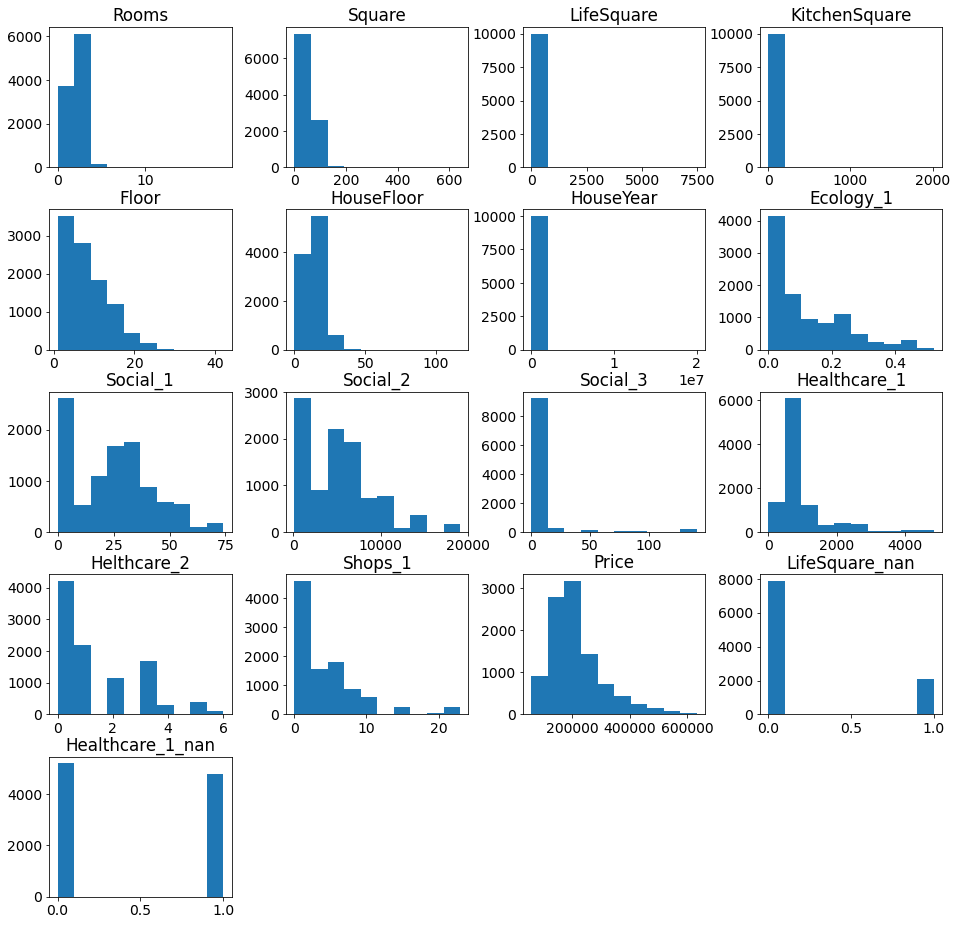

In [27]:
df.hist(figsize=(16,16), bins=10, grid=False);

Дополнительно посмотрим матрицу корреляций

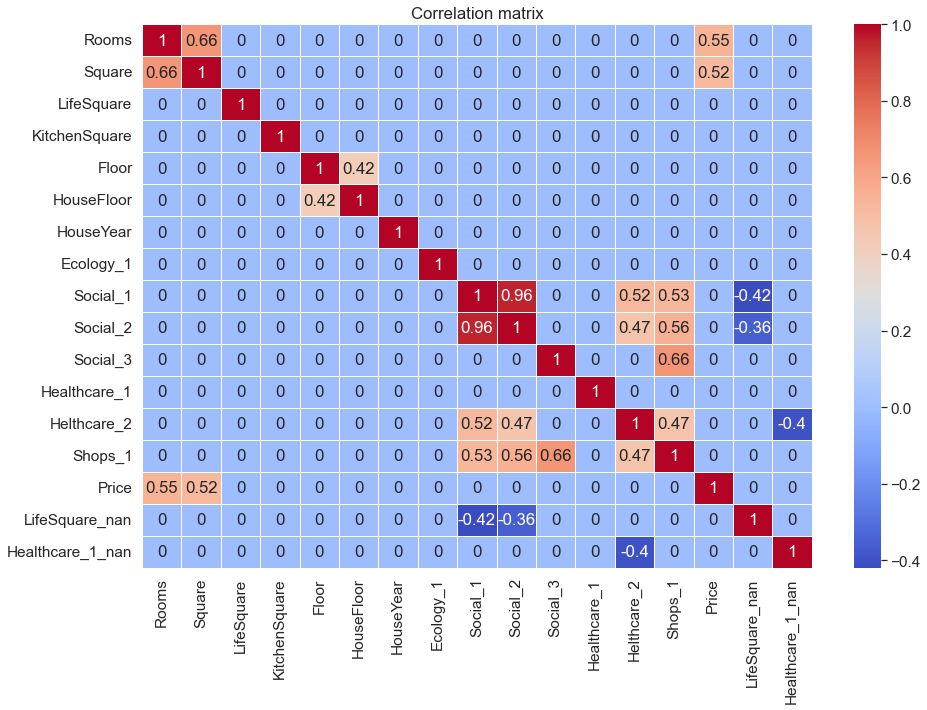

In [28]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

***HouseYear***

In [29]:
df['HouseYear'].unique()

array([    2014,     1966,     1988,     1977,     1972,     1968,
           1986,     2008,     1978,     2012,     1969,     2003,
           1981,     1962,     2015,     2018,     1976,     1985,
           1960,     2019,     1974,     1956,     1963,     1961,
           1979,     2006,     1953,     1973,     1982,     1965,
           2007,     2013,     1983,     1995,     1971,     2017,
           1964,     1991,     1990,     2016,     2011,     1984,
           1993,     1997,     2009,     1975,     2010,     1987,
           1935,     1970,     1967,     1989,     1959,     1996,
           2005,     1994,     1958,     2004,     1998,     1992,
           1980,     2000,     2002,     1954,     2001,     1999,
           1917,     1955,     1957,     1934,     2020,     1932,
           1942,     1940,     1937,     1941,     1939,     1931,
           1951,     1912,     1918,     1952,     1919,     1936,
           1930,     1938,     1950,     1933,     1929,     1

In [30]:
import datetime

In [31]:
now = datetime.datetime.now()
now.year

2022

In [32]:
df.loc[df.HouseYear > now.year, 'HouseYear'] = now.year

***Square, LifeSquare, KitchenSquare***

Для обработки выборосов по данным признакам, я решила рассчитать процент жилой площади от общей

In [33]:
[df['Square'].describe(), df['LifeSquare'].describe()]

[count    10000.000000
 mean        56.315777
 std         21.058731
 min          1.136859
 25%         41.774879
 50%         52.513309
 75%         65.900627
 max        641.065186
 Name: Square, dtype: float64,
 count    10000.000000
 mean        36.266037
 std         76.609985
 min          0.370619
 25%         25.527400
 50%         32.781261
 75%         41.427234
 max       7480.592285
 Name: LifeSquare, dtype: float64]

In [34]:
df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [35]:
total_square_max_value = df['Square'].quantile(.95)
total_life_square_max_value = df['LifeSquare'].quantile(.95)
total_square_min_value = df['Square'].quantile(.05)
total_life_square_min_value = df['LifeSquare'].quantile(.05)
total_kitchen_square_max_value = df['KitchenSquare'].quantile(.95)
total_kitchen_square_min_value = df['KitchenSquare'].quantile(.05)


In [36]:
condition_square = (df['Square'] > total_square_max_value) | \
                    (df['Square'] < total_square_min_value)| \
                    (df['Square'].isna())

condition_life_square = (df['LifeSquare'] > total_life_square_max_value) | \
                        (df['LifeSquare'] < total_life_square_min_value) | \
                        (df['LifeSquare'].isna())

condition_kitchen_square = (df['KitchenSquare'] > total_kitchen_square_max_value) | \
                        (df['KitchenSquare'] < total_kitchen_square_min_value) | \
                        (df['KitchenSquare'].isna())| \
                        ((df['KitchenSquare'] > 1) & (df['KitchenSquare'] < 5))

In [37]:
df.loc[condition_square, 'Square'] = df['Square'].median()
df.loc[condition_life_square, 'LifeSquare'] = df['LifeSquare'].median()
df.loc[condition_kitchen_square, 'KitchenSquare'] = df['KitchenSquare'].median()

In [38]:
df['Square'].describe()

count    10000.000000
mean        54.569206
std         13.501912
min         34.169300
25%         43.094318
50%         52.513309
75%         63.373323
max         87.846970
Name: Square, dtype: float64

In [39]:
df['LifeSquare'].describe()

count    10000.000000
mean        33.981174
std          9.529461
min         18.469284
25%         29.525537
50%         32.781261
75%         37.290589
max         64.800781
Name: LifeSquare, dtype: float64

In [40]:
df['KitchenSquare'].describe()

count    10000.000000
mean         5.505800
std          3.615809
min          0.000000
25%          1.000000
50%          6.000000
75%          8.000000
max         12.000000
Name: KitchenSquare, dtype: float64

***Square transform***

Решила сопоставить общую площадь и площадь жилую и кухни

In [41]:
condition = (df['Square'].isna()) \
             | ((df['KitchenSquare'] + df['LifeSquare']) > df['Square'])
        
df.loc[condition, 'Square'] = (df['KitchenSquare'] + df['LifeSquare']) + 3


In [42]:
df['Square'].describe()

count    10000.000000
mean        55.280186
std         13.441274
min         34.169300
25%         44.057414
50%         52.513309
75%         64.367542
max         87.846970
Name: Square, dtype: float64

***HouseFloor, Floor***

In [43]:
df['HouseFloor'].describe(), df['Floor'].describe()

(count    10000.000000
 mean        12.609400
 std          6.775974
 min          0.000000
 25%          9.000000
 50%         13.000000
 75%         17.000000
 max        117.000000
 Name: HouseFloor, dtype: float64,
 count    10000.000000
 mean         8.526700
 std          5.241148
 min          1.000000
 25%          4.000000
 50%          7.000000
 75%         12.000000
 max         42.000000
 Name: Floor, dtype: float64)

In [44]:
condition = ((df['HouseFloor'] > (np.quantile(df['HouseFloor'], q=0.95)))| \
            (df['HouseFloor'] < (np.quantile(df['HouseFloor'], q=0.05)))| \
              (df['HouseFloor'].isna()))

In [45]:
df.loc[condition, 'HouseFloor'] = df['HouseFloor'].median()
df['HouseFloor'].describe()

count    10000.000000
mean        12.366600
std          5.532582
min          1.000000
25%          9.000000
50%         13.000000
75%         17.000000
max         24.000000
Name: HouseFloor, dtype: float64

Заменим этажи в выбросах, на максимальный этаж в доме, если мы будем заменять на медиану, то у нас могут получится данные, где этаж больше чем высотность дома

In [46]:
condition = (df['HouseFloor'] < df['Floor']) \
            | (df['Floor'].isna())

In [47]:
df.loc[condition, 'Floor'] = df['HouseFloor']

In [48]:
df['HouseFloor'].describe(), df['Floor'].describe()

(count    10000.000000
 mean        12.366600
 std          5.532582
 min          1.000000
 25%          9.000000
 50%         13.000000
 75%         17.000000
 max         24.000000
 Name: HouseFloor, dtype: float64,
 count    10000.000000
 mean         7.748100
 std          4.845637
 min          1.000000
 25%          4.000000
 50%          7.000000
 75%         11.000000
 max         24.000000
 Name: Floor, dtype: float64)

***Rooms***

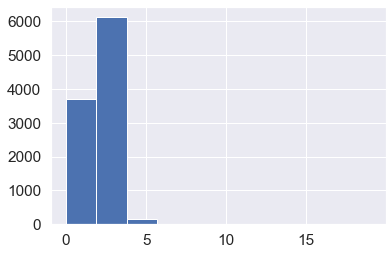

In [49]:
df['Rooms'].hist();

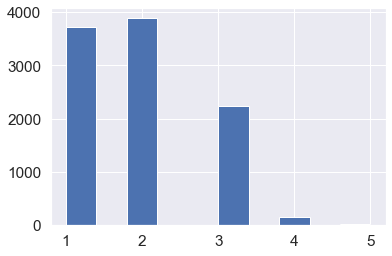

In [50]:
df.loc[df['Rooms'] == 0, 'Rooms'] = 1
df.loc[df['Rooms'] > 5, 'Rooms'] = df['Rooms'].median()
df['Rooms'].hist();

***Social_2, Social_3***

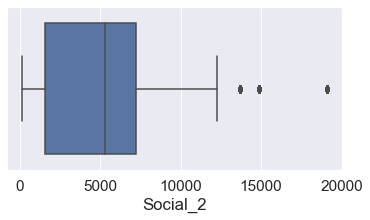

In [51]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Social_2'], whis=1)

plt.xlabel('Social_2')
plt.show()

In [52]:
df.loc[df['Social_2'] > 10000, 'Social_2'] = df['Social_2'].median()

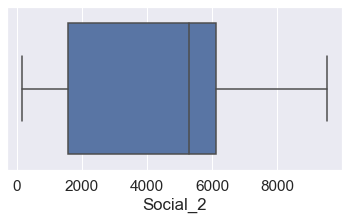

In [53]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Social_2'], whis=1)

plt.xlabel('Social_2')
plt.show()

In [54]:
df['Social_3'].describe()

count    10000.000000
mean         8.039200
std         23.831875
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max        141.000000
Name: Social_3, dtype: float64

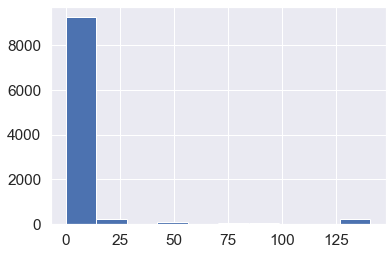

In [55]:
df['Social_3'].hist();

In [56]:
df.loc[df['Social_3'] > 10, 'Social_3'] = df['Social_3'].median()

In [57]:
df['Social_3'].describe()

count    10000.000000
mean         2.223600
std          2.394447
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: Social_3, dtype: float64

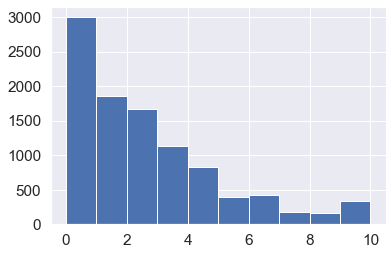

In [58]:
df['Social_3'].hist();

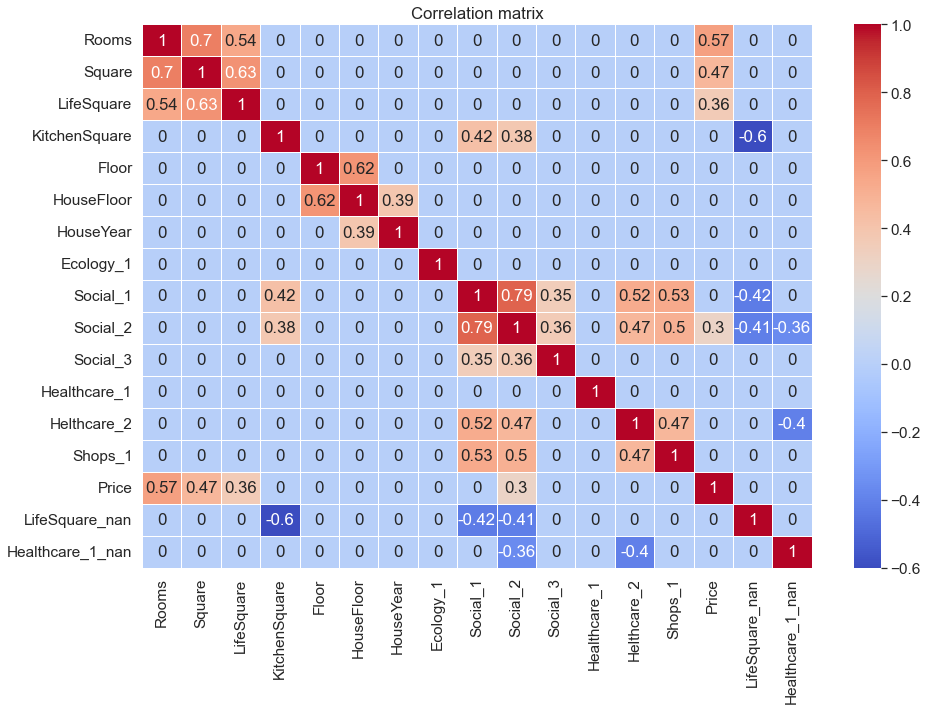

In [59]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

После обработки данных появилось больше признаков, влияющих на целевую переменную

### 2. Очистка данных

In [60]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.quantile_max = None
        self.quantile_min = None
        

        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет медиан
        self.medians = df[['LifeSquare', 'Healthcare_1', 'KitchenSquare', 'Square',
                           'HouseFloor', 'Social_2', 'Social_3', 'Rooms']].median()
        
        # Расчет квантиль
        self.quantile_max = df[['KitchenSquare', 'Square', 'LifeSquare','HouseFloor']].quantile(.95)
        self.quantile_min = df[['KitchenSquare', 'Square', 'LifeSquare','HouseFloor']].quantile(.05)

        
    def transform(self, df):
        """Трансформация данных"""
        
        df['DistrictId'] = df['DistrictId'].astype(str)
        
        if 'Id' in df.columns:
            df.drop(columns=['Id'], inplace=True)
        
        df['LifeSquare_nan'], df['Healthcare_1_nan'] = [0, 0]
        df.loc[df['LifeSquare'].isna(), 'LifeSquare_nan']= 1
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_nan']= 1
        
        # 1. Пропуски
        
        df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = self.medians['LifeSquare']
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = self.medians['Healthcare_1']
       
        
        # 2. Выбросы (outliers)

        
        #HouseYear
        
        df.loc[df.HouseYear > 2022 | df['HouseYear'].isna(), 'HouseYear'] = 2022
        
        #Square, LifeSquare, KitchenSquare
        
        condition_square = (df['Square'] > self.quantile_max['Square']) | \
                    (df['Square'] < self.quantile_min['Square'])| \
                    (df['Square'].isna())

        condition_life_square = (df['LifeSquare'] > self.quantile_max['LifeSquare']) | \
                        (df['LifeSquare'] < self.quantile_min['LifeSquare']) | \
                        (df['LifeSquare'].isna())
        
        condition_kitchen_square = (df['KitchenSquare'] > self.quantile_max['KitchenSquare']) | \
                        (df['KitchenSquare'] < self.quantile_min['LifeSquare']) | \
                        (df['KitchenSquare'].isna())| \
                        ((df['KitchenSquare'] > 1) & (df['KitchenSquare'] < 5)) 
                        
        
        
        df.loc[condition_square, 'Square'] = self.medians['Square']
        df.loc[condition_life_square, 'LifeSquare'] = self.medians['LifeSquare']
        df.loc[condition_kitchen_square, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        #Square transfom
        
        condition = (df['Square'].isna()) \
             | ((df['KitchenSquare'] + df['LifeSquare']) > df['Square'])
        
        df.loc[condition, 'Square'] = (df['KitchenSquare'] + df['LifeSquare']) + 3
        
        #HouseFloor, Floor
        
        condition = ((df['HouseFloor'] > self.quantile_max['HouseFloor'])| \
                    (df['HouseFloor'] < self.quantile_min['HouseFloor'])| \
                      (df['HouseFloor'].isna()))
        
        df.loc[condition, 'HouseFloor'] = self.medians['HouseFloor']
        
        condition = (df['HouseFloor'] < df['Floor']) \
            | (df['Floor'].isna())
        
        df.loc[condition, 'Floor'] = df['HouseFloor']
        
        #Rooms
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
        df.loc[df['Rooms'] > 6, 'Rooms'] = self.medians['Rooms']
        
        #Social_2, Social_3
        
        df.loc[df['Social_2'] > 10000, 'Social_2'] = self.medians['Social_2']
        df.loc[df['Social_3'] > 10, 'Social_3'] = self.medians['Social_3']
        
        
        #df.fillna(self.medians, inplace=True)
                
        return df

### 3. Построение новых признаков

In [61]:
binary_to_numbers = {'A': 0, 'B': 1}

df['Ecology_2'] = df['Ecology_2'].replace(binary_to_numbers)
df['Ecology_3'] = df['Ecology_3'].replace(binary_to_numbers)
df['Shops_2'] = df['Shops_2'].replace(binary_to_numbers)

In [62]:
def age_to_cat(X):
    now = datetime.datetime.now()
    age = (now.year - X['HouseYear'])
    X['age_cat'] = 0

    X.loc[age <= 5, 'age_cat'] = 1  
    X.loc[(age > 5) & (age <= 10), 'age_cat'] = 2
    X.loc[(age > 10) & (age <= 25), 'age_cat'] = 3
    X.loc[age > 25, 'age_cat'] = 4

    return X

In [63]:
df = age_to_cat(df)
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Healthcare_1_nan,age_cat
0,27,3.0,52.513309,32.781261,10.0,4,10.0,2014,0.075424,1,...,3097,0,900.0,0,0,1,305018.875000,1,1,2
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,...,6207,1,1183.0,1,0,1,177734.546875,0,0,4
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,5261,0,240.0,3,1,1,282078.718750,0,0,4
3,1,1.0,40.409908,32.781261,1.0,10,22.0,1977,0.007122,1,...,264,0,900.0,0,1,1,168106.000000,1,1,4
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,8667,2,900.0,0,6,1,343995.093750,0,1,4


Добавим признак многокомнтных квартир

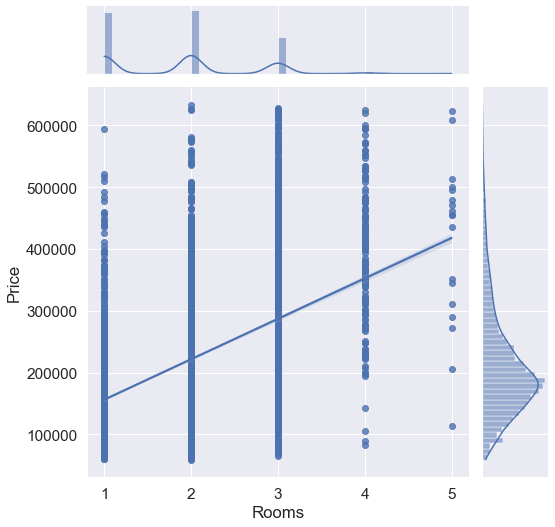

In [64]:
grid = sns.jointplot(df['Rooms'], df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

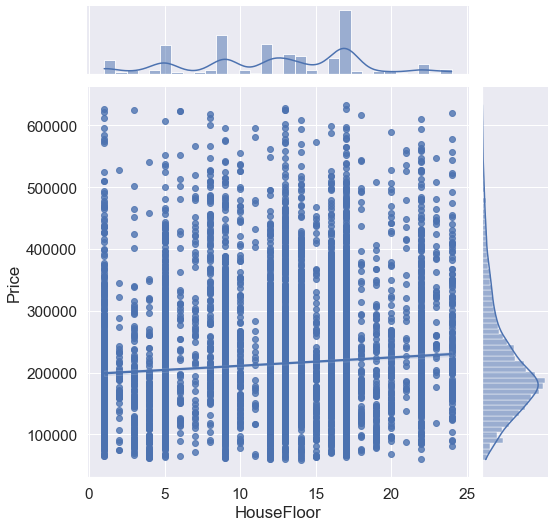

In [65]:
grid = sns.jointplot(df['HouseFloor'], df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [66]:
df['many_rooms'] = (df['Rooms'] > 3) * 1
df['many_rooms'].value_counts()

0    9832
1     168
Name: many_rooms, dtype: int64

***med_price_by_House***

Я решила построить зависимость от года и этажности дома, исходя из того, что многие любят жить в малоэтажных районах

In [67]:
df['HouseFloor'].describe()

count    10000.000000
mean        12.366600
std          5.532582
min          1.000000
25%          9.000000
50%         13.000000
75%         17.000000
max         24.000000
Name: HouseFloor, dtype: float64

In [68]:
def housefloor_to_cat(df):

    df['HouseFloor_cat'] = 0

    df.loc[df['HouseFloor'] <= 3, 'HouseFloor_cat'] = 1  
    df.loc[(df['HouseFloor'] > 3) & (df['HouseFloor'] <= 5), 'HouseFloor_cat'] = 2
    df.loc[(df['HouseFloor'] > 5) & (df['HouseFloor'] <= 13), 'HouseFloor_cat'] = 3
    df.loc[(df['HouseFloor'] > 13) & (df['HouseFloor'] <= 17), 'HouseFloor_cat'] = 4
    df.loc[df['HouseFloor'] > 17, 'HouseFloor_cat'] = 5

    return df

In [69]:
df = housefloor_to_cat(df)
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Healthcare_1_nan,age_cat,many_rooms,HouseFloor_cat
0,27,3.0,52.513309,32.781261,10.0,4,10.0,2014,0.075424,1,...,900.0,0,0,1,305018.875000,1,1,2,0,3
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,...,1183.0,1,0,1,177734.546875,0,0,4,0,3
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,240.0,3,1,1,282078.718750,0,0,4,0,4
3,1,1.0,40.409908,32.781261,1.0,10,22.0,1977,0.007122,1,...,900.0,0,1,1,168106.000000,1,1,4,0,5
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,900.0,0,6,1,343995.093750,0,1,4,0,4


In [70]:
med_price_by_House = df.groupby(['age_cat', 'HouseFloor_cat'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByHouse'})

med_price_by_House.head()

,age_cat,HouseFloor_cat,MedPriceByHouse
0,1,1,172374.781250
1,1,2,139768.281250
2,1,3,202224.171875
3,1,4,166784.500000
4,1,5,240710.859375


In [71]:
med_price_by_House.shape

(20, 3)

In [72]:
df = df.merge(med_price_by_House, on=['age_cat','HouseFloor_cat'], how='left')
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Healthcare_1_nan,age_cat,many_rooms,HouseFloor_cat,MedPriceByHouse
0,27,3.0,52.513309,32.781261,10.0,4,10.0,2014,0.075424,1,...,0,0,1,305018.875000,1,1,2,0,3,171399.140625
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,...,1,0,1,177734.546875,0,0,4,0,3,197124.921875
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,3,1,1,282078.718750,0,0,4,0,4,188707.734375
3,1,1.0,40.409908,32.781261,1.0,10,22.0,1977,0.007122,1,...,0,1,1,168106.000000,1,1,4,0,5,200440.671875
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,0,6,1,343995.093750,0,1,4,0,4,188707.734375


In [73]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.district_size = None
        self.med_price_by_floor_year_median = None
        
    def fit(self, df, y=None):
        
        df = df.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        
           
        # Target encoding
        ## District
        df = df.copy()
        
                 
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.housefloor_to_cat(df)
            df = self.age_to_cat(df)
            
            self.med_price_by_floor_year = df.groupby(['age_cat', 'HouseFloor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByHouse'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByHouse'].median()
        

        
    def transform(self, df):
        
        # Binary features
        df['Ecology_2'] = df['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        df['Ecology_3'] = df['Ecology_3'].map(self.binary_to_numbers)
        df['Shops_2'] = df['Shops_2'].map(self.binary_to_numbers)
        

        
        # More categorical features
        df = self.housefloor_to_cat(df)  # + столбец HouseFloor_cat
        df = self.age_to_cat(df)   # + столбец age_cat
        
         
        # Target encoding

        if self.med_price_by_floor_year is not None:
            
            df = df.merge(self.med_price_by_floor_year, on=['age_cat', 'HouseFloor_cat'], how='left')
            df['MedPriceByHouse'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        df['many_rooms'] = (df['Rooms'] > 3) * 1
        
        return df
    
    def housefloor_to_cat(self, df):

        df['HouseFloor_cat'] = 0

        df.loc[df['HouseFloor'] <= 3, 'HouseFloor_cat'] = 1  
        df.loc[(df['HouseFloor'] > 3) & (df['HouseFloor'] <= 5), 'HouseFloor_cat'] = 2
        df.loc[(df['HouseFloor'] > 5) & (df['HouseFloor'] <= 13), 'HouseFloor_cat'] = 3
        df.loc[(df['HouseFloor'] > 13) & (df['HouseFloor'] <= 17), 'HouseFloor_cat'] = 4
        df.loc[df['HouseFloor'] > 17, 'HouseFloor_cat'] = 5

        return df
     
    def age_to_cat(self, df):
        now = datetime.datetime.now()
        age = (now.year - df['HouseYear'])
        df['age_cat'] = 0

        df.loc[age <= 5, 'age_cat'] = 1  
        df.loc[(age > 5) & (age <= 10), 'age_cat'] = 2
        df.loc[(age > 10) & (age <= 25), 'age_cat'] = 3
        df.loc[age > 25, 'age_cat'] = 4

        return df

###  4. Отбор признаков

In [74]:
df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'LifeSquare_nan',
 'Healthcare_1_nan',
 'age_cat',
 'many_rooms',
 'HouseFloor_cat',
 'MedPriceByHouse']

In [144]:
feature_names = ['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'Floor',
 'HouseFloor',
 'Ecology_1',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'many_rooms',
 'HouseFloor_cat',
 'MedPriceByHouse']

target_name = 'Price'

### Разбиение на train / test 

In [145]:
train_df = pd.read_csv(DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [147]:
X_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

In [148]:
datapipeline = DataPipeline()
datapipeline.fit(X_train)

X_train = datapipeline.transform(X_train)
X_test = datapipeline.transform(X_test)
test_df = datapipeline.transform(test_df)

X_train.shape, X_test.shape, test_df.shape

((6700, 20), (3300, 20), (5000, 20))

In [149]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_test = features_gen.transform(X_test)
test_df = features_gen.transform(test_df)

X_train.shape, X_test.shape, test_df.shape

((6700, 24), (3300, 24), (5000, 24))

In [150]:
X_train.isna().sum().sum(), X_test.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [151]:
X_train = X_train[feature_names]
X_test = X_test[feature_names]
test_df = test_df[feature_names]

In [183]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=15,
                                 min_samples_leaf=10,
                                 random_state=50,
                                 n_estimators=200 )
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_depth=15, min_samples_leaf=10,
                      n_estimators=200, random_state=50)

Train R2:	0.778
Test R2:	0.649


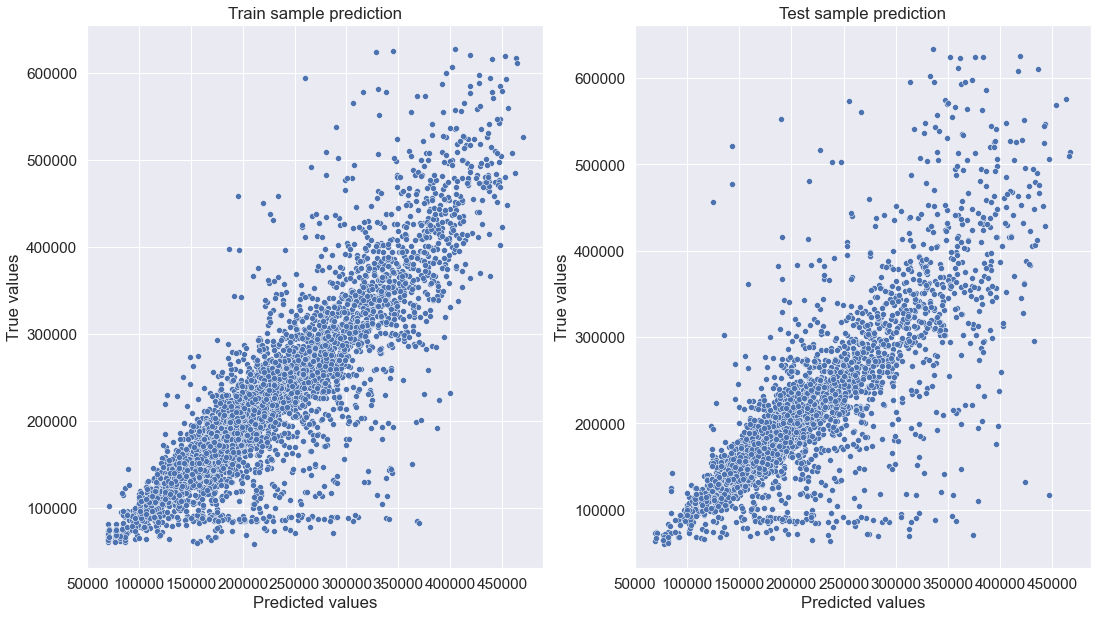

In [184]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [154]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.65390713, 0.65083303, 0.6646207 ])

In [155]:
cv_score.mean()

0.6564536200369693

In [157]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)


,feature_name,importance
1,Rooms,0.398529
2,Square,0.120294
9,Social_2,0.101615
8,Social_1,0.095377
0,DistrictId,0.054405
6,Ecology_1,0.043280
10,Social_3,0.041982
3,LifeSquare,0.041190
5,HouseFloor,0.038587
11,Healthcare_1,0.018863


In [164]:
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
gb = GradientBoostingRegressor()

stack = StackingRegressor([('lr', lr), ('rf', rf_model)], final_estimator=gb)
stack.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('rf',
                               RandomForestRegressor(criterion='mse',
                                                     max_depth=15,
                                                     min_samples_leaf=10,
                                                     n_estimators=200,
                                                     random_state=50))],
                  final_estimator=GradientBoostingRegressor())

Train R2:	0.763
Test R2:	0.647


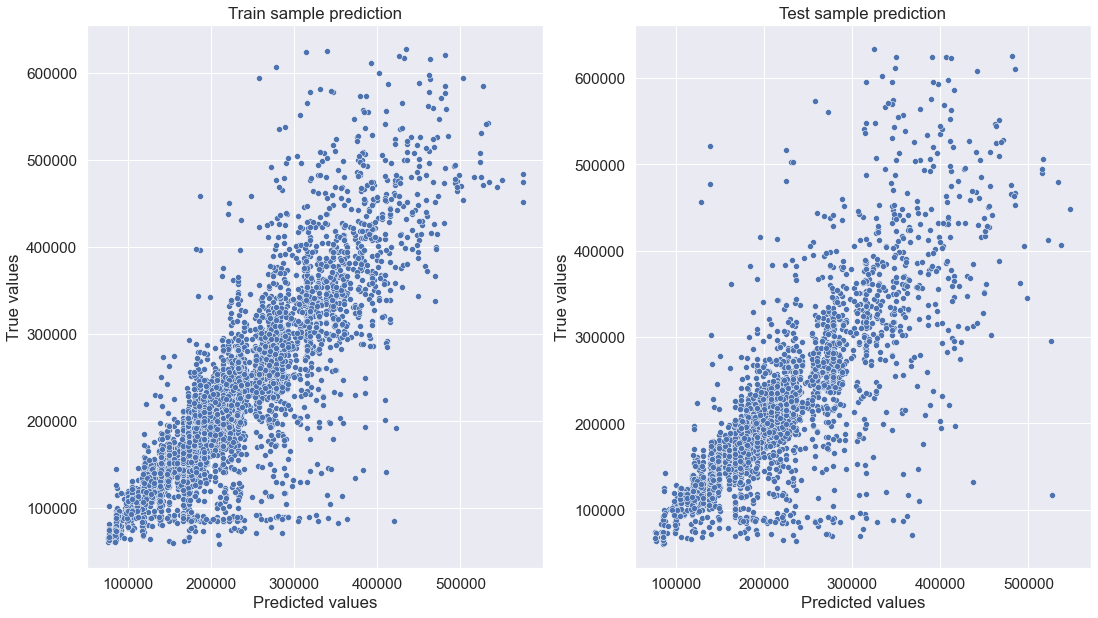

In [165]:
y_train_preds = stack.predict(X_train)
y_test_preds = stack.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

***StackingRegressor*** модель показала результат хуже

Решила использовать просто бустинг с подбором параметров

In [166]:
gb_model = GradientBoostingRegressor(criterion='mse',
                          min_samples_leaf=10,
                          random_state=42,
                         # n_estimators=100,
                         # max_depth=7
                         )

In [194]:
#%%time
#params = {'n_estimators':[50, 100, 200], 
          #'max_depth':[3, 5, 7, 10],
           #'min_samples_leaf':[5, 10, 15, 20]}

#gs = GridSearchCV(gb_model, params, 
                  #scoring='r2', # метрика 
                  #cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           #random_state=21, 
                           #shuffle=True),
                  #n_jobs=-1
                 #)
#gs.fit(X_train, y_train)

CPU times: total: 3.91 s
Wall time: 1min 20s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 min_samples_leaf=10,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [5, 10, 15, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

In [195]:
gs.best_params_

{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 200}

In [196]:
gs.best_score_

0.6973175072465652

In [209]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=5,
                                        min_samples_leaf=5,
                                        random_state=50,
                                        n_estimators=200)
final_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=5,
                          n_estimators=200, random_state=50)

Train R2:	0.863
Test R2:	0.681


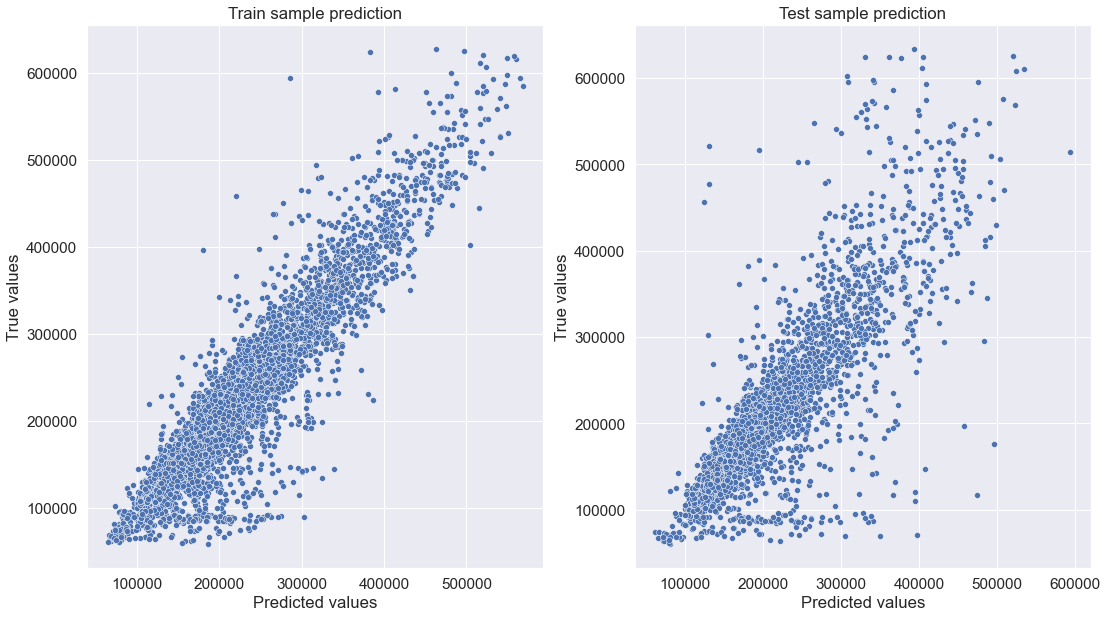

In [210]:
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

# Предсказание на тестовом датасете

In [211]:
test_df.shape

(5000, 18)

In [213]:
sample_PATH = './sample_submission.csv'

In [214]:
submit = pd.read_csv(sample_PATH, sep=',')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [215]:
predictions = final_model.predict(test_df)
predictions

array([169610.94410785, 128457.37313286, 142576.791382  , ...,
       138257.92104191, 185941.5664567 , 262758.64701182])

In [216]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,169610.944108
1,5925,128457.373133
2,960,142576.791382
3,3848,155873.844574
4,746,182856.790317


In [217]:
submit.to_csv('gb_submit.csv', index=False)